# Entity extraction on Financial Complaints with Watson NLP

This notebook demonstrates how to extract _named entities_ from financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Dictionary-based term extraction** with the _Rule-based extractor_ provided by `watson_nlp.resources.feature_extractor.RBR`. This allows you to train a custom extraction model based on given dictionaries.

- **Entity extraction** with the _Entity mentions block_ using the BERT model (`entity-mentions_bert_multi_stock`). This block extracts mentions of entities like *Persion*, *Organization* or *Duration* from the input text.


## Table of Contents

1.	[Before you start](#beforeYouStart)
2.	[Load the complaints](#loadData)
3.  [Custom term extraction using dictionaries](#dictionaries)
4.  [Entity extraction](#entities)
5.  [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _NLP_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [1]:
from tqdm import tqdm

In [3]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [6]:
import watson_nlp

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [7]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [8]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/15/21,Debt collection,Auto debt,Attempts to collect debt not owed,Debt is not yours,FBCS/XXXX XXXXXXXX I REQUESTED DEBT VALIDATION. THEY SENT ME A STATEMENT ONLY. \nI REQUESTED SOMETHING THAT I SIGNED,Company believes it acted appropriately as authorized by contract or law,Financial Business and Consumer Solutions.,FL,33460,None,Consent provided,Web,03/24/21,Closed with explanation,Yes,NaN,4215137
1,03/10/21,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt was paid,I received a letter from Debt Recovery Solutions on XX/XX/XXXX that stated I owed {$240.00} to XXXX XXXX for an unpaid payday loan.. I disregarded the letter bc I do not owe XXXX XXXX anything and I currently have a payday loan with them and you cant have a new loan unless the other one is paid off. The next day I was notified by XXXX and XXXX and XXXX about a collection from Debt Recovery...,None,"Debt Recovery Solutions, LLC",FL,33170,Servicemember,Consent provided,Web,03/10/21,Closed with explanation,Yes,NaN,4197767
2,03/11/21,Mortgage,VA mortgage,Trouble during payment process,None,"I sold a VA backed property in XX/XX/XXXX, Selene finance has held the money I am due from a mortgage insurance reimbursement since XX/XX/XXXX, according to 12 CFR part 1024 ( Regulation X ) 1024.34 ( b ) Refund of escrow balance ( 1 ) In general. Except as provided in paragraph ( b ) ( 2 ) of this section, within 20 days ( excluding legal public holidays, XXXX, and XXXX XXXX of a borrower 's ...",None,Selene Holdings LLC,IN,47432,Servicemember,Consent provided,Web,03/11/21,Closed with explanation,Yes,NaN,4204566


You can look at all products that are available in the data set to do further analysis around these product groups.

<AxesSubplot:>

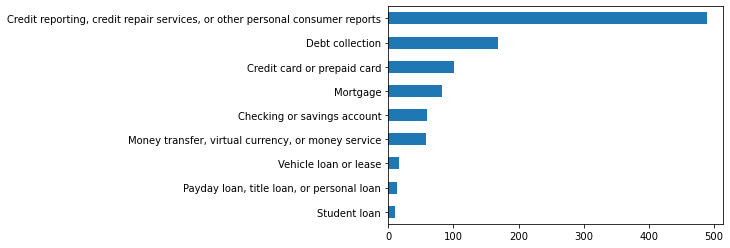

In [9]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate customers suspecting a fraud concerning their financial products like the theft of a credit card.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [10]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the fraud-related terms divided into *FRAUD* and *THEFT*. Each line has one dictionary entry.

In [11]:
fraud_file = "fraud_mappings.csv"
with open(os.path.join(RBR_dicts_folder, fraud_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"FRAUD\", \"fraud\"\n")
    dict.write("\"FRAUD\", \"takeover\"\n")
    dict.write("\"FRAUD\", \"skimming\"\n")
    dict.write("\"FRAUD\", \"phishing\"\n")
    dict.write("\"THEFT\", \"theft\"\n")
    dict.write("\"THEFT\", \"thief\"\n")
    dict.write("\"THEFT\", \"thieve\"\n")
    dict.write("\"THEFT\", \"steal\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match, for example, "steal" -> "stole", "stolen", "stealing".

In [12]:
dictionary = watson_nlp.toolkit.DictionaryConfig.load( 
    {
        'name': 'fraud_mappings',
        'source': fraud_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the unterlying AQL code.

In [13]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='en', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single complaint. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediatly, you will access the raw response from the underlying RBR executor.

In [14]:
def extract_dictionary(complaint_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(complaint_text, language='en')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the complaint text.

In [29]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Fraud Indicators'})
# combine with the complaint dataframe
text_dict_matches_df = df[["Product", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)
text_dict_matches_df.head(10)

,Product,Consumer complaint narrative,Fraud Indicators
0,Debt collection,FBCS/XXXX XXXXXXXX I REQUESTED DEBT VALIDATION. THEY SENT ME A STATEMENT ONLY. \nI REQUESTED SOMETHING THAT I SIGNED,[]
1,Debt collection,I received a letter from Debt Recovery Solutions on XX/XX/XXXX that stated I owed {$240.00} to XXXX XXXX for an unpaid payday loan.. I disregarded the letter bc I do not owe XXXX XXXX anything and I currently have a payday loan with them and you cant have a new loan unless the other one is paid off. The next day I was notified by XXXX and XXXX and XXXX about a collection from Debt Recovery...,"[(FRAUD, fraud)]"
2,Mortgage,"I sold a VA backed property in XX/XX/XXXX, Selene finance has held the money I am due from a mortgage insurance reimbursement since XX/XX/XXXX, according to 12 CFR part 1024 ( Regulation X ) 1024.34 ( b ) Refund of escrow balance ( 1 ) In general. Except as provided in paragraph ( b ) ( 2 ) of this section, within 20 days ( excluding legal public holidays, XXXX, and XXXX XXXX of a borrower 's ...",[]
3,Debt collection,"I have been contacted -- called directly, my sister has been called, and I have been getting physical mail -- by Alpha Recovery Corp . \n\nAddress : XXXX XXXX XXXX XXXX Unit XXXX XXXX CO, XXXX They state that I owe {$8400.00} from XXXX debt. I have contact XXXX directly and have confirmed that I owe no such debt, and they have advised me not to give any information to this collections company ...",[]
4,Mortgage,"I contacted Loan Depot in XXXX XXXX, CA about a refinance on XX/XX/2021. They collected all of my information and stopped returning my calls or responding to inquiries. I made attempts to call and email them on several occasions, including XX/XX/2021, XX/XX/2021, XX/XX/2021, and XX/XX/2021. They are not responding. However, I received a call from my insurance company that they changed themselv...",[]
5,"Credit reporting, credit repair services, or other personal consumer reports",This is my THIRD AND FINAL WARNING before filing litigation against Nissan Motor Acceptance and XXXX \nThe Fair Credit Reporting Act ( FCRA ) requires consumer reporting agencies to follow reasonable procedures to assure maximum possible accuracy of the information concerning the individual about whom the report relates. 15 U.S.C. 1681e ( b ). XXXX has violated that code section by failing to ...,"[(THEFT, theft), (THEFT, theft)]"
6,Credit card or prepaid card,XX/XX/2021 my cash card through cash app was fraudulently used without my permission or acknowledgement. I didnt find out about until the XX/XX/2021. Cash app never reached out to me to alert me of the unauthorized transactions. Even though it shows the used an old bank account debit card ending in XXXX that was linked to my cash app account a month ago. I was scammed out of {$2100.00} back in...,"[(FRAUD, fraud)]"
7,Credit card or prepaid card,"CNB VISA # XXXX On XX/XX/XXXX, a letter was sent out to me that, effective XX/XX/XXXX, my VISA # XXXX at the City National Bank would be closed, and effective immediately, my credit line at the bank is being reduced from {$20000.00} to {$18000.00}. There was no clear reason mentioned on that notice, only that the bank is exiting out of the banking relationship. I am filing this complaint to ge...",[]
8,"Credit reporting, credit repair services, or other personal consumer reports","I do not know how this works, but I need it done or somehow corrected. My name is XXXX XXXX DOB XXXX SS XXXX. I had some issues with my income being effected by the COVID-19 PANDEMIC SHUTDOWN. I was under the 1 CARES Act, Pub. L. 116-136, section 4021, codified at FCRA section 623 ( a ) ( 1 ) ( F ) ( i ) ( I ), 15 U.S.C. 1681s- 2 ( a ) ( 1 ) ( F ) ( i ) ( I ). I am requesting some accommodatio...",[]
9,Debt collection,"XXXX, XXXX XXXX SOC SEC # XXXX DOB XX/XX/1968 ADDRESS XXXX XXXX XXXX, XXXX, FL XXXX CAPITAL ACCOUNTS XXXX Your company have violated FCRA 615 ( f ) ( 15 U.S.C. 1681m ( f ) ) ( f ) Prohibition on sale or transfer of

Notice that "stolen" was detected as *THEFT* as the base-form *steal* is contained in the dictionary and you used lemma-matching.

How many complaints talk about *THEFT* or *FRAUD* or both? Count the complaints for each product group and display the relative frequency: 

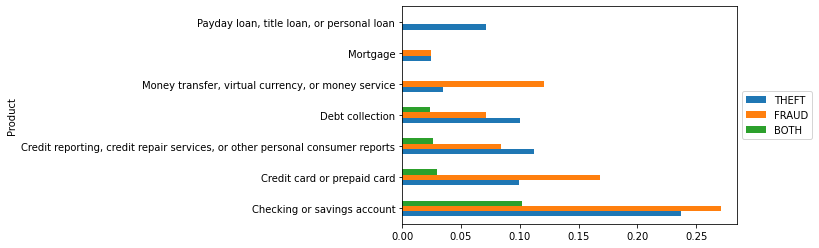

In [17]:
# create a column indicating if the complaint contains at least one *FRAUD* or *THEFT* match
text_dict_matches_df['THEFT'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'THEFT' in set([match[0] for match in matches]))
text_dict_matches_df['FRAUD'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]) and 'THEFT' in set([match[0] for match in matches]))

# get the relative frequency by product group
perc_theft = text_dict_matches_df.groupby('Product')['THEFT'].value_counts(normalize=True)
perc_fraud = text_dict_matches_df.groupby('Product')['FRAUD'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('Product')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_theft, perc_fraud, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('Product')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Nearly 15% of the Money transfer/service complaints seem to deal with theft and over 25% of the checking or savings account complaints with fraud.

<a id="entities"></a>
## Entity extraction

The complaints contain a lot of entity mentions about entities like organizations, money, durations, etc. In this section you will learn how to use the BERT entity mention extraction block, which extracts entity mentions out-of-the-box. 

The BERT entity mention model depends on the syntax model. Start with loading both models:

In [18]:
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
bert_entity_model = watson_nlp.load('entity-mentions_bert_multi_stock')

The helper method first runs the syntax model and then the entity extraction model on top of the syntax result:

In [19]:
def extract_entities(complaint_text):
    # run syntax model
    syntax_result = syntax_model.run(complaint_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the entity mention model on the result of the syntax model
    entity_mentions = bert_entity_model.run(syntax_result)
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the complaint dataframe and show the extracted entities along with the complaint text.<br/> **Note:** This cell will run for several minutes. For better progress feedback, the cell is using `progress_apply` from the `tqdm` library. You can also use `apply` from `pandas` directly, i.e. `df[text_col].apply(..)`

In [26]:
from tqdm.notebook import tqdm
tqdm.pandas(colour='green')

In [27]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].progress_apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})
# combine with our complaint dataframe
text_entities_df = df[["Product", text_col]].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,Product,Consumer complaint narrative,Entities
0,Debt collection,FBCS/XXXX XXXXXXXX I REQUESTED DEBT VALIDATION. THEY SENT ME A STATEMENT ONLY. \nI REQUESTED SOMETHING THAT I SIGNED,[]
1,Debt collection,I received a letter from Debt Recovery Solutions on XX/XX/XXXX that stated I owed {$240.00} to XXXX XXXX for an unpaid payday loan.. I disregarded the letter bc I do not owe XXXX XXXX anything and I currently have a payday loan with them and you cant have a new loan unless the other one is paid off. The next day I was notified by XXXX and XXXX and XXXX about a collection from Debt Recovery...,"[(Debt Recovery Solutions, Organization), ($240.00, Money), (next day, Date), (Debt Recovery Solutions, Organization), (Monday XX/XX/, Date), (Debt Recovery Solutions, Organization), (3 weeks, Duration), (Tuesday XX/XX/, Date), (Debt Recovery Solutions, Organization), (3rd, Ordinal), (bc Debt Recovery Solutions, Organization), (XXXX, Organization), (Debt Recovery Solutions, Organization), (XXX..."
2,Mortgage,"I sold a VA backed property in XX/XX/XXXX, Selene finance has held the money I am due from a mortgage insurance reimbursement since XX/XX/XXXX, according to 12 CFR part 1024 ( Regulation X ) 1024.34 ( b ) Refund of escrow balance ( 1 ) In general. Except as provided in paragraph ( b ) ( 2 ) of this section, within 20 days ( excluding legal public holidays, XXXX, and XXXX XXXX of a borrower 's ...","[(VA, Organization), (Selene, Location), (XX, Date), (20 days, Duration), (65 days, Duration)]"
3,Debt collection,"I have been contacted -- called directly, my sister has been called, and I have been getting physical mail -- by Alpha Recovery Corp . \n\nAddress : XXXX XXXX XXXX XXXX Unit XXXX XXXX CO, XXXX They state that I owe {$8400.00} from XXXX debt. I have contact XXXX directly and have confirmed that I owe no such debt, and they have advised me not to give any information to this collections company ...","[(Alpha Recovery Corp, Organization), (XXXX, Location), (Unit, Location), (XXXX XXXX CO,, Location), ($8400.00, Money), (XXXX, Organization), (Alpha Recovery, Organization), (Alpha Recovery Corp, Organization), (manager, JobTitle), (first, Ordinal)]"
4,Mortgage,"I contacted Loan Depot in XXXX XXXX, CA about a refinance on XX/XX/2021. They collected all of my information and stopped returning my calls or responding to inquiries. I made attempts to call and email them on several occasions, including XX/XX/2021, XX/XX/2021, XX/XX/2021, and XX/XX/2021. They are not responding. However, I received a call from my insurance company that they changed themselv...","[(Loan Depot, Organization), (XXXX XXXX, CA, Location), (XX/XX/2021, Date), (2021, Date)]"


Let's see what kind of entities are extracted from the complaints:

<AxesSubplot:>

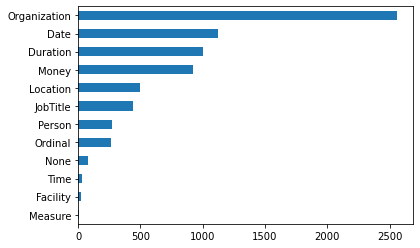

In [21]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create separate rows for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by product:

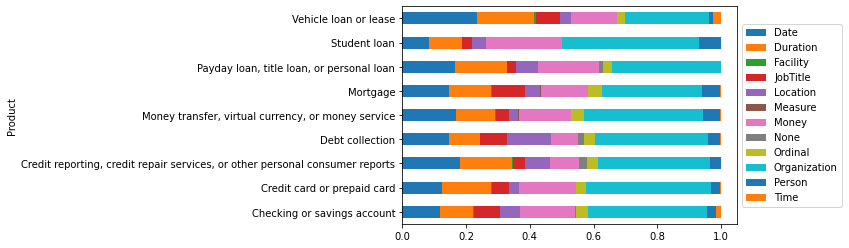

In [22]:
unstacked = exp_entities.groupby('Product')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Job Titles* are frequently mentioned in the *Vechicle loan or lease* product group and there is a high number of *Location* mentions for the product group *Debt collection*. Let's look at some sample texts for the job titles:

In [23]:
exp_entities.query('`Entity Type` == "JobTitle" and Product == "Vehicle loan or lease"').head()

,Product,Consumer complaint narrative,Entities,Entity Type
69,Vehicle loan or lease,"I have an auto loan with Bank of America. I made my regular payment on XX/XX/2021. I made an extra payment of {$1000.00} on XX/XX/2021. I expected it to be applied to the principal. Instead, my next payment due date was moved out until XX/XX/2021. I called their helpline and was told there should be an option to apply to principal but no such option could be found while on the call. They said ...","(principal, JobTitle)",JobTitle
131,Vehicle loan or lease,"We bought a truck and used Bank of the West for the loan. Everything was fine until XXXX. I was a dental assistant and was sent home from work, with no notice because of covid19. I applied for unemployment benefits but could not get any help for months. I contacted Bank of the west in XXXX and applied for help. I got their Disaster relief plan, and they told me it should be fine. Well they hav...","(dental assistant, JobTitle)",JobTitle
393,Vehicle loan or lease,"XXXX XXXX XXXX XXXX XXXX XXXX . \nXXXX XXXX, Mo XXXX To : XXXX XXXX XXXX XXXX XXXX, This complaint is against GM Financial on ground of price gouging by changing a payoff on a vehicle. Allow me to explain. \n\nIn XX/XX/XXXX my fianc past away with a XXXX XXXX XXXX, being financed by GM Financial. According to the bill for that month, the owed balance was about {$9000.00}. Later I advised the ...","(executive, JobTitle)",JobTitle
565,Vehicle loan or lease,"I was a current owner of a XXXX XXXX, purchased at Al XXXX XXXX. My current loan was active and up to date, it was an automatic payment set up. I went in for maintenance on XX/XX/XXXX at Al XXXX and was approached by a salesman to up grade to a XXXX XXXX. I agreed to the trade and was told I would not have any payments for 3 months due to the pandemic and they would contact me once they are ab...","(salesman, JobTitle)",JobTitle
672,Vehicle loan or lease,"In XXXX of XXXX we notified XXXX that the vehicle was having mechanical issues and we were not able to get it registered or fixed. Our account was severely delinquent for the past year, we would make a payment only when an email was sent advising the date of repossession. We recently were forced XXXX XXXX the vehicle and it experienced engine trouble resulting it not being able to be moved. Th...","(representatives, JobTitle)",JobTitle


<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained model for entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.